# Imports

In [2]:
import sympy as sp
import numpy as np
from scipy.integrate import quad
from scipy.stats import lognorm
# from physipy import units, constants
from scipy.optimize import curve_fit, fsolve
import matplotlib.pyplot as plt
from matplotlib import cm
sp.init_printing(use_latex=True)
from scipy.constants import epsilon_0, mu_0, pi, c, e, electron_mass

import matplotlib.ticker as mtick
import seaborn as sns
import pandas as pd
import time
import re
import os
from sklearn.linear_model import LinearRegression
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from typing import List, Dict, Any, Tuple, Pattern
from scipy.signal import find_peaks

from google import genai
from google.genai import types

MODEL_ID = "gemini-2.5-flash-preview-05-20"

api_key = os.environ.get("GEMINI_API_KEY")
client = genai.Client(api_key=api_key)

response = client.models.generate_content(
    model=MODEL_ID,
    contents="test",
)

print(response.text)

Understood! How can I help you today?


# Aerosol Optics, Aerosol Spectroscopy, Scattering, EM

## Introduction (Particle size distribution)

From A. Kokhanovsky book "Aerosol Optics":

The optical properties of aerosol particles are largely determined by the ratio  $a/\lambda$,
where $\lambda$ is the wavelength of incident light and $a$ is the characteristic size of a particle
(radius of droplet or a side of a cubic crytal). Therefore, information on typical sizes of sea-salt particles
is of great importance for aerosol optics. This has  been studied in numerous experiments. In particular,
Clarke et al. (2005) found that dry sizes of sea-salt particles are in the range $0.1$ to $10\ \mu\text{m}$.
The number concentration $N$ of sea-salt particles in the open ocean is usually around $250\ \text{cm}^{-3}$.
The value of $N$ of sea-salt particles with typical sizes around $0.3\ \mu\text{m}$. The particle size distribution
of sea-salt aerosol is usually modeled using the lognormal law:

$a$ $-$ radius of spherical homogeneous particle

$\sigma=0.9$

$a_0=0.3\ \mu\text{m}$


### Python examples

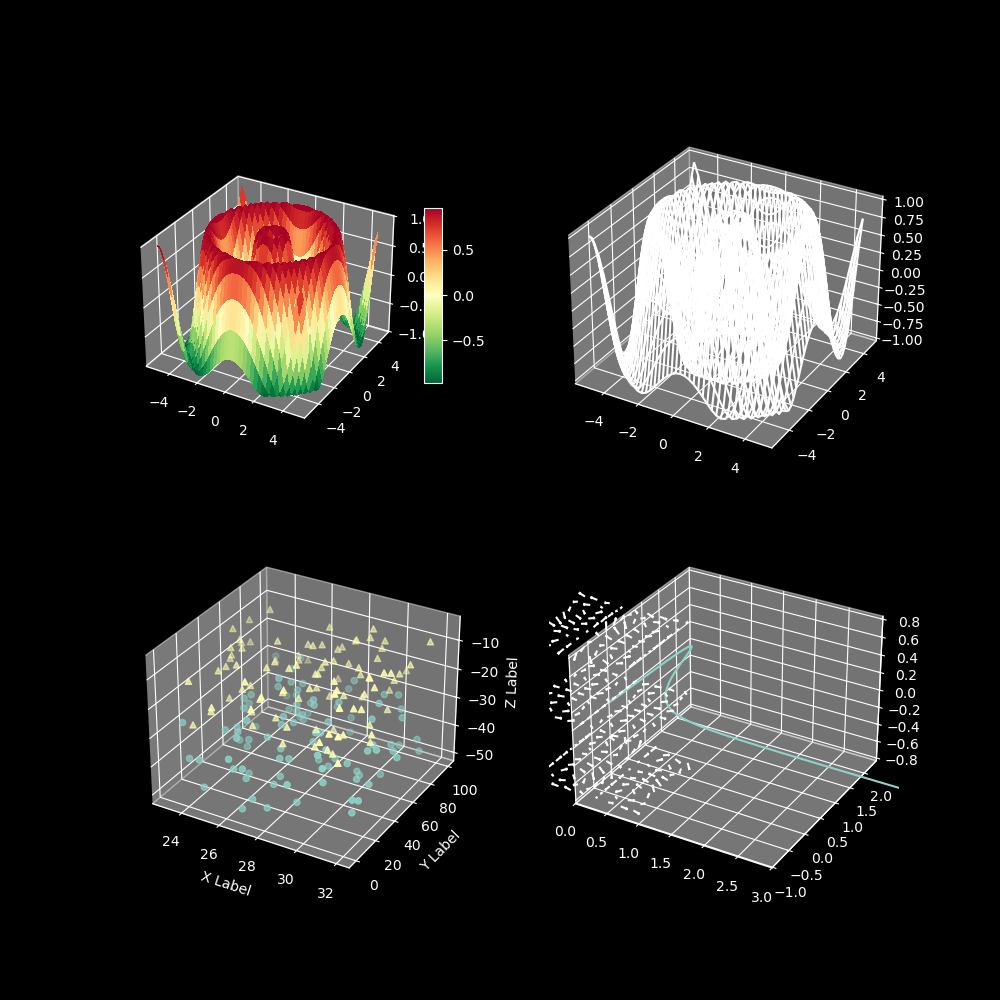

In [26]:
s = 0.9
mu = 0.3
x = np.linspace(lognorm.ppf(0.0000001, s), lognorm.ppf(0.999, s), 1000)
plt.plot(x, lognorm.pdf(x, s, scale=mu), "-", label="lognorm pdf")
plt.xlim(0, 3)
plt.grid("true")
plt.show()

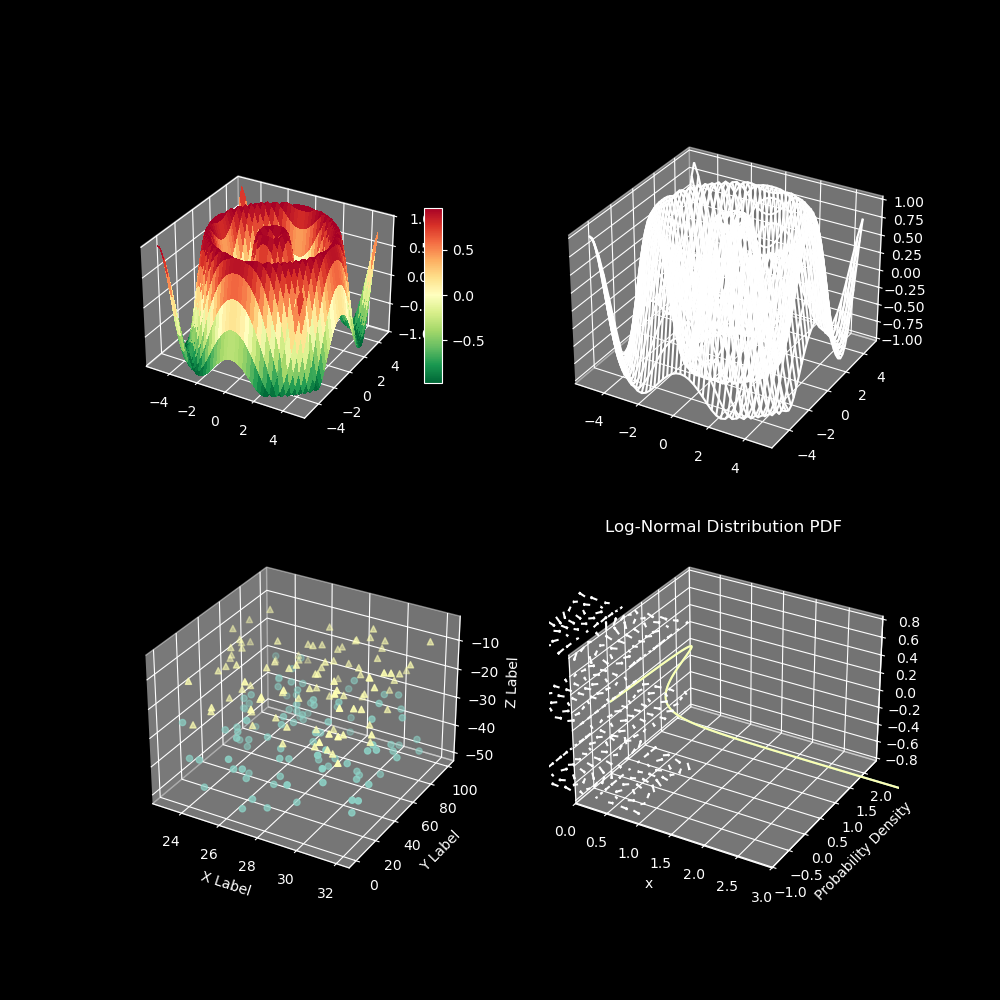

Integral from 0 to infinity: 0.9999999999995361
0.44979075001765884
0.5024603563372585
1.117098020173896


In [27]:
# Parameters for the log-normal distribution
mu = 0.3  # Mean
sigma = 0.9  # Standard deviation

x = np.linspace(0.01, 10, 1000)  # Start from nonzero

pdf = lognorm.pdf(x, sigma, scale=mu)
def avg_size_integrand(x, sigma, mu):
    return x*lognorm.pdf(x, sigma, scale=mu)

def avg_size(sigma, mu):
    return quad(avg_size_integrand, 0, np.inf, args=(sigma, mu))[0]

def stdev_integrand(x, sigma, mu):
    return (x - avg_size(sigma, mu))**2*lognorm.pdf(x, sigma, scale=mu)

def stdev(sigma, mu):
    return np.sqrt(quad(stdev_integrand, 0, np.inf, args=(sigma, mu))[0])

# Calculate the integral from 0 to infinity
integral, error = quad(lognorm.pdf, 0, np.inf, args=(sigma, mu))
test_avg_size = avg_size(sigma, mu)
test_stdev = stdev(sigma, mu)
test_c = test_stdev / test_avg_size


# Plot the PDF
plt.plot(x, pdf)
plt.title('Log-Normal Distribution PDF')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

# Print the integral
print(f"Integral from 0 to infinity: {integral}")
print(test_avg_size)
print(test_stdev)
print(test_c)

\frac{\sqrt{2} \int \frac{e^{\frac{\log{\left(\frac{x}{\mu} \right)}^{2}}{2 \sigma^{2}}}}{x}\, dx}{2 \sqrt{\pi} \sigma}


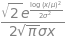

In [28]:
x, mu, sigma = sp.symbols('x mu sigma')
psd_lognormal = ((1/(sp.sqrt(2*sp.pi)*sigma*x))) * sp.exp((sp.ln(x/mu)**2)/(2*sigma**2))
f_psd_lognormal = sp.lambdify([sigma, x, mu], psd_lognormal)
integrated_psd = sp.integrate(psd_lognormal, x)
print(sp.latex(integrated_psd))
# integrated_psd
psd_lognormal

The area under normalized lognormal distribution (integral 0 to +inf) should be 1:
1.0000000000006777

Log normal distribution with (sigma=1, mu=1, x=1)
0.3989422804014327

Average size of particle with (sigma, mu)=(0.9, 0.3):
0.4497907500176589

0.44979075001703
Both approaches (1.12 and 1.12) should equal  approximately:
True

0.5024603563372585
2.2728332833895966
1.2479079866768072
2.2728332833910545
1.2479079866764717
(1.0000000000006777, 5.8382518746042135e-09)


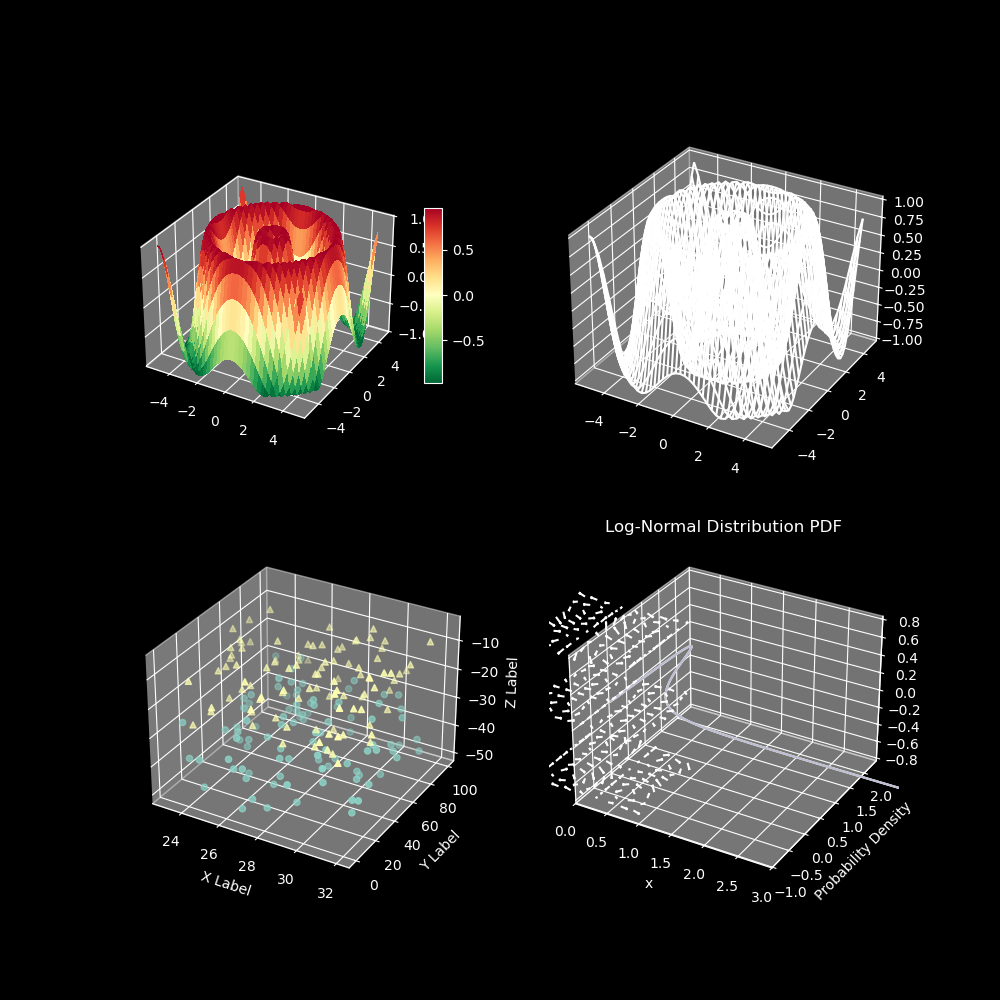

In [29]:


sigma, mu = 0.9, 0.3 # in micrometers
x_values = np.linspace(0.01, 10, 1000)

def lognormal(x, sigma, mu):
    front_coef = 1 / (np.sqrt(2*np.pi)*sigma*x)
    exp_power = -np.log(x/mu)**2/(2*sigma**2)
    return front_coef*np.exp(exp_power)

def avg_size_integrand(x: float, sigma: float, mu: float) -> float:  # noqa: F811
    front_coef = 1 / (np.sqrt(2*np.pi)*sigma*x)
    exp_power = -np.log(x/mu)**2/(2*sigma**2)
    return x*front_coef*np.exp(exp_power)

def avg_size_integrand_alt(x, sigma, mu):
    return x*lognorm.pdf(x, sigma, scale=mu)

def avg_size(sigma, mu):
    return quad(avg_size_integrand, 0, np.inf, args=(sigma, mu))[0]

def avg_size_alt(sigma, mu):
    return quad(avg_size_integrand_alt, 0, np.inf, args=(sigma, mu))[0]

def stdev_integrand(x, sigma, mu):  # noqa: F811
    return (x - avg_size(sigma, mu))**2*lognormal(x, sigma, mu)

def stdev_delta(sigma, mu):
    return np.sqrt(quad(stdev_integrand, 0, np.inf, args=(sigma, mu))[0])





def effective_radius_numerator_integrand(x, sigma, mu):
    return x**3*lognormal(x, sigma, mu)

def effective_radius_denominator_integrand(x, sigma, mu):
    return x**2*lognormal(x, sigma, mu)

def effective_radius_numerator(sigma, mu):
    return quad(effective_radius_numerator_integrand, 0, np.inf, args=(sigma, mu))[0]

def effective_radius_denominator(sigma, mu):
    return quad(effective_radius_denominator_integrand, 0, np.inf, args=(sigma, mu))[0]

def effective_radius(sigma, mu):
    return effective_radius_numerator(sigma, mu) / effective_radius_denominator(sigma, mu)

def effective_variance_numerator_integrand(x, sigma, mu):
    return (x-effective_radius(sigma, mu))**2*x**2*lognormal(x, sigma, mu)

def effective_variance_numerator(sigma, mu):
    return quad(effective_variance_numerator_integrand, 0, np.inf, args=(sigma, mu))[0]

def effective_variance_denominator_integrand(x, sigma, mu):
    return x**2*lognormal(x, sigma, mu)

def effective_variance_denominator(sigma, mu):
    return effective_radius(sigma, mu)**2*quad(effective_variance_denominator_integrand, 0, np.inf, args=(sigma, mu))[0]

def effective_variance(sigma, mu):
    return effective_variance_numerator(sigma, mu) / effective_variance_denominator(sigma, mu)

# FAST FUNCTIONS

def big_c(sigma):
    return np.sqrt(np.exp(sigma**2) - 1)

def a_bar(sigma, mu):
    return mu*np.exp(0.5*sigma**2)

def effective_radius_alt(sigma, mu):
    return mu*np.exp(2.5*sigma**2)

def effective_variance_alt(sigma):
    return np.exp(sigma**2) - 1

def modal_radius(sigma: float, mu: float) -> float:
    return mu*np.exp(-sigma**2)

def n_particles(sigma, mu):
    return quad(lognormal, 0, np.inf, args=(sigma, mu))



test_lognormal = lognormal(1, 1, 1)
test_quad = quad(lognormal, 0, np.inf, args=(sigma, mu))
test_avg_size = quad(avg_size_integrand, 0, np.inf, args=(sigma, mu))[0]
test_avg_size_alt = quad(avg_size_integrand_alt, 0, np.inf, args=(sigma, mu))[0]
test_stdev = stdev_delta(sigma, mu)
coef_of_variance = test_stdev / test_avg_size
test_big_c = big_c(sigma)
test_a_bar = a_bar(sigma, mu)
test_coef_again = test_stdev / test_a_bar
test_effective_radius = effective_radius(sigma, mu)
test_effective_variance = effective_variance(sigma, mu)
test_effective_radius_alt = effective_radius_alt(sigma, mu)
test_effective_variance_alt = effective_variance_alt(sigma)
test_n_particles = n_particles(sigma, mu)

print( f"The area under normalized lognormal distribution (integral 0 to +inf) should be 1:\n{test_quad[0]}\n" )
print(f"Log normal distribution with (sigma=1, mu=1, x=1)\n{ test_lognormal }\n")
print(f"Average size of particle with (sigma, mu)=({sigma}, {mu}):\n{ test_avg_size }\n")
# print(test_avg_size_alt) # <-------- much slower. Use custom numpy functions!
print(f"{ test_a_bar }")
print(f"Both approaches ({coef_of_variance:.2f} and {test_big_c:.2f}) should equal  approximately:\n{ round(test_big_c, 2) == round(coef_of_variance, 2) }\n")
print(test_stdev)
print(test_effective_radius)
print(test_effective_variance)
print(test_effective_radius_alt)
print(test_effective_variance_alt)
print(test_n_particles)

plt.plot(x_values, lognormal(x_values, sigma=sigma, mu=mu))
plt.xlim(0, 3)
plt.grid(True)
plt.show()

### Timing tests

In [30]:
%timeit test_stdev_2 = stdev_delta(sigma, mu)

198 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit test_stdev_1 = test_big_c * test_a_bar

50.5 ns ± 3.54 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [32]:
%timeit test_big_c = big_c(sigma)

1.5 μs ± 31.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [33]:
# the fastest!!!
%timeit test_a_bar = a_bar(sigma, mu)

820 ns ± 46.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [34]:
# manually written function using python math syntax
%timeit test_avg_size = quad(avg_size_integrand, 0, np.inf, args=(sigma, mu))[0]

647 μs ± 60.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
# using scipy
%timeit test_avg_size_alt = quad(avg_size_integrand_alt, 0, np.inf, args=(sigma, mu))[0]

16.9 ms ± 349 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Various forms and quantities from particle size distribution

$f(a)\equiv \dfrac{d N}{d a} = \dfrac{1}{a} \dfrac{d N}{d\ln a} = \dfrac{1}{a\ln 10}\dfrac{dN}{d\log{a}} = \dfrac{1}{\pi a^2}\dfrac{dS}{da} = \dfrac{3}{4\pi a^3}\dfrac{dV}{da} = \dfrac{3}{4\pi a^4}\dfrac{dV}{d\ln a} = \dfrac{3}{4\pi\rho a^3}\dfrac{dM}{da}$

$C_{sca}$ --> Scattering XS (cross-section)

$C_{abs}$ --> Absorption XS

$I_0$ --> intensity of incident light

$I_{sca}$ --> intensity of scattered light

$S$ --> Surface surrounding the particle

$V$ --> Volume of the particle

$G$ --> Geometrical XS (projection of particle onto the plane perpendicular to the beam propagation direction)

$k$ --> $k=2\pi/\lambda$

$\vec{E_0}$ --> Electric vector of the incident wave

$\vec{E}$ --> Electric vector inside the scatterer

$C_{sca}=\displaystyle\frac{1}{I_0}\displaystyle\int_SI_{sca}dS$

$C_{abs}=\displaystyle\frac{k}{\left|\vec{E_0}\right|^2}\displaystyle\int_{V}\left|\vec{E}\right|^2\epsilon''dV$

### Examples from website

In [36]:

# === Example 5: Complex Permittivity & Wave Propagation ===

c0 = c

def calculate_wave_properties(eps_r, sigma, freq_hz, mu_r=1.0):
    """
    Calculates complex permittivity, wave number, and related
    propagation constants for a material at a given frequency.
    Uses e^-iwt convention.

    Args:
        eps_r (float): Relative permittivity (real part).
        sigma (float): Conductivity (S/m).
        freq_hz (float): Frequency (Hz).
        mu_r (float): Relative permeability (default 1.0 for non-magnetic).

    Returns:
        dict: Dictionary containing calculated properties, or None if freq invalid.
    """
    if freq_hz <= 0:
        print("ERROR: Frequency must be positive.")
        return None

    omega = 2 * pi * freq_hz
    mu_abs = mu_r * mu_0      # Absolute permeability

    # 1. Calculate Relative Complex Permittivity (eps_c_rel = e'r + i*e''r)
    eps_prime_rel = eps_r
    eps_double_prime_rel = sigma / (omega * epsilon_0)
    eps_c_rel = complex(eps_prime_rel, eps_double_prime_rel)

    # 2. Calculate Absolute Complex Permittivity (eps_c = eps_0 * eps_c_rel)
    epsilon_c_abs = epsilon_0 * eps_c_rel

    # 3. Calculate Complex Wave Number (k = w * sqrt(mu * eps_c))
    # Handle the square root branch correctly for attenuation (alpha > 0)
    # k = beta + i*alpha for e^(ikz) propagation term where alpha represents loss.
    sqrt_term = np.sqrt(mu_abs * epsilon_c_abs + 0j) # Ensure input is complex
    k = omega * sqrt_term

    # Ensure the imaginary part (alpha) is positive for physical attenuation
    if k.imag < 0:
        k = -k

    beta = k.real   # Phase constant (rad/m)
    alpha = k.imag  # Attenuation constant (nepers/m)

    # 4. Calculate other useful properties
    wavelength_medium = 2 * pi / beta if beta > 1e-9 else float('inf')
    # Penetration depth (delta = 1/alpha)
    penetration_depth = 1 / alpha if alpha > 1e-9 else float('inf')
    # Attenuation in dB/m
    alpha_db_per_m = 20 * alpha / np.log(10) # approx 8.686 * alpha_np
    # Phase velocity (vp = omega / beta)
    phase_velocity = omega / beta if beta > 1e-9 else float('inf')
    # Refractive index (complex: n_c = sqrt(mu_r * eps_c_rel) = c0/vp + i*c0*alpha/omega)
    n_complex = c0 * k / omega # Complex refractive index n + ikappa
    refractive_index_real = n_complex.real
    extinction_coefficient = n_complex.imag

    return {
        "frequency_ghz": freq_hz / 1e9,
        "eps_r": eps_r,
        "sigma_sm": sigma,
        "eps_c_relative": eps_c_rel,
        "eps_prime_relative": eps_prime_rel,
        "eps_double_prime_relative": eps_double_prime_rel,
        "wavenumber_k": k,
        "phase_constant_beta_rad_m": beta,
        "attenuation_alpha_np_m": alpha,
        "attenuation_alpha_db_m": alpha_db_per_m,
        "wavelength_m": wavelength_medium,
        "penetration_depth_m": penetration_depth,
        "phase_velocity_m_s": phase_velocity,
        "complex_refractive_index": n_complex,
        "refractive_index_n": refractive_index_real,
        "extinction_coeff_kappa": extinction_coefficient
    }

# --- Run Examples ---
print("--- Example 1: Low-Loss Material (e.g., Glass @ 1 THz) ---")
props1 = calculate_wave_properties(eps_r=4.0, sigma=1e-4, freq_hz=1e12)
if props1:
    print(f"  Rel. εc ≈ {props1['eps_c_relative']:.3f}")
    print(f"  Wave# k ≈ {props1['wavenumber_k'].real:.1f} + {props1['wavenumber_k'].imag:.4f}j rad/m")
    print(f"  Attrib α ≈ {props1['attenuation_alpha_db_m']:.3f} dB/m (Low)")
    print(f"  Wavelen λ ≈ {props1['wavelength_m']*1e6:.1f} μm") # Micrometers
    print(f"  Pen. Depth δ ≈ {props1['penetration_depth_m']:.2f} m")
    print(f"  Phase Vel. vp ≈ {props1['phase_velocity_m_s']/c0:.3f} c")
    print(f"  Complex Index nc ≈ {props1['complex_refractive_index']:.3f}")

print("\n--- Example 2: Lossy Material (Muscle Tissue @ 2.45 GHz) ---")
# Approximate values for biological tissue
props2 = calculate_wave_properties(eps_r=47.0, sigma=1.8, freq_hz=2.45e9)
if props2:
    print(f"  Rel. εc ≈ {props2['eps_c_relative']:.3f}")
    print(f"  Wave# k ≈ {props2['wavenumber_k'].real:.1f} + {props2['wavenumber_k'].imag:.1f}j rad/m")
    print(f"  Attrib α ≈ {props2['attenuation_alpha_db_m']:.1f} dB/m (High)")
    print(f"  Wavelen λ ≈ {props2['wavelength_m']*100:.2f} cm") # Centimeters
    print(f"  Pen. Depth δ ≈ {props2['penetration_depth_m']*100:.2f} cm") # Penetration is cm!
    print(f"  Phase Vel. vp ≈ {props2['phase_velocity_m_s']/c0:.3f} c")
    print(f"  Complex Index nc ≈ {props2['complex_refractive_index']:.3f}")
        

--- Example 1: Low-Loss Material (e.g., Glass @ 1 THz) ---
  Rel. εc ≈ 4.000+0.000j
  Wave# k ≈ 41916.9 + 0.0094j rad/m
  Attrib α ≈ 0.082 dB/m (Low)
  Wavelen λ ≈ 149.9 μm
  Pen. Depth δ ≈ 106.18 m
  Phase Vel. vp ≈ 0.500 c
  Complex Index nc ≈ 2.000+0.000j

--- Example 2: Lossy Material (Muscle Tissue @ 2.45 GHz) ---
  Rel. εc ≈ 47.000+13.206j
  Wave# k ≈ 355.4 + 49.0j rad/m
  Attrib α ≈ 425.5 dB/m (High)
  Wavelen λ ≈ 1.77 cm
  Pen. Depth δ ≈ 2.04 cm
  Phase Vel. vp ≈ 0.144 c
  Complex Index nc ≈ 6.922+0.954j


In [37]:
def unitvector(vec):
    return np.array(vec).T / np.linalg.norm(np.array(vec).T)

unitvector([1, 1, 1])

array([0.57735027, 0.57735027, 0.57735027])

# EM

## Coulumb's law



Given two charges $q_1$ and $q_2$, distance $\mathbf{r}$ apart, Coulumb's law is as follows:

$\begin{equation}
\boxed{\mathbf{F}_2 = \displaystyle\frac{1}{4\pi\epsilon_0} \frac{q_1q_2\mathbf{\hat{r}}_{21}}{r^2_{21}}}
\end{equation}$

$\mathbf{\hat{r}}_{ab}$ is a unit vector in direction $a\to b$, and $\mathbf{F}_a$ is force exerted on $q_2$ due to $q_1$

$\epsilon_0 \approx 8.854 \cdot 10^{-12}\ \text{[N}\cdot\text{m}^2\cdot\text{C}^{-2}\text{]}$

Elementary charge (charge of electron) is $e \approx 1.602\cdot10^{-19}\ \text{[C]}$



## Energy of a system of charges

Let's say we have a system of charges $q_1$ and $q_2$. To somehow configure or move one charge w.r.t. other, it takes the negative Coulumb's force for the system.

$\begin{equation}
\allowbreak\displaystyle W=\int\text{(applied force)}\cdot\text{(displacement)}
=\int_{r=\infty}^{r_{12}}\left(-\frac{1}{4\pi\epsilon_0}\frac{q_1q_2}{r^2}\right)dr
=\frac{1}{4\pi\epsilon_0}\frac{q_1q_2}{r_{12}}
\end{equation}$

In three charge system, this would amount to

$\begin{equation}
\displaystyle U = \frac{1}{4\pi\epsilon_0}\left(\frac{q_1q_2}{r_{12}}+\frac{q_1q_3}{r_{13}}+\frac{q_2q_3}{r_{23}}\right)
\end{equation}$

Above, $U$ is potential of the system with three charges. First, we bring in $q_2$ to $q_1$, then we bring in $q_3$ to the $q_1$, $q_2$ pair.
We take into account the superposition principle: multiple particle effects on another particle can be summed into one effect.

If we want to generalize this, we can write:

$\begin{equation}
\displaystyle \boxed{U=\frac{1}{2} \displaystyle\sum_{j=1}^N\displaystyle\sum_{k\not= j}\frac{1}{4\pi\epsilon_0}\frac{q_jq_k}{r_{jk}}}
\end{equation}$

Double sum notation means: take $j=1$, sum over $k=2,3,4\mathellipsis$; then take $j=2$, sum over $k=1,3,4\mathellipsis$ etc. After this, we have included everything twice, so we need to put constant $\frac{1}{2}$ in front of the double sum.

## Electric field

If we take a test charge $q_0$ (which actually is not part of a system), and calculate the force on it exerted by a system of charges, we get:

$\begin{equation}
\displaystyle \mathbf{F} = \frac{1}{4\pi\epsilon_0}\displaystyle\sum_{j=1}^{N}\frac{q_0q_j\mathbf{\hat{r}}_{0j}}{r_0^2}
\end{equation}$

If we now divide (5) by $q_0$, we get *electric field* $\mathbf{E}$:

$\begin{equation}
\mathbf{E}(x,y,z) = \frac{1}{4\pi\epsilon_0}\displaystyle\sum_{j=1}^N\frac{q_j\mathbf{\hat{r}}_{0j}}{r_{0j}^2}
\end{equation}$

Shorthand for force exerted on some charge $q$ at $(x,y,z)$ exerted by some field $\mathbf{E}$ is:

$\begin{equation}
\boxed{\mathbf{F}=q\mathbf{E}}
\end{equation}$

## Field vectors and Maxwell equations

We will try to write out vector calculus operators (grad, div, curl) in python or try to understand from the internet/LLM sources, how to use them from the ready packages. Mostly, we should use only `numpy`, because that will be faster than `scipy`.

But first let's define them here on the paper:

Grad is short for gradient. In my personal experience, it is basically just the same as derivative. For a 3D function $f = f(x, y, z)$, it writes out as this:

$
\begin{equation}
\nabla{f} = \left(\dfrac{\partial}{\partial x}, \dfrac{\partial}{\partial y}, \dfrac{\partial}{\partial z}\right)f=\dfrac{\partial f}{\partial x}\hat{\textbf{\i}}+\dfrac{\partial f}{\partial y}\hat{\textbf{\j}}+\dfrac{\partial f}{\partial z}\hat{\textbf{k}}
\end{equation}
$

In this situation $f$ is a ___scalar field___ and applying a gradient returns a ___vector field___. And $\textbf{i}, \textbf{j}, \textbf{k}$ are unit vectors.

In Cartesian coordinates, divergence of continuously differentiable vector field $\mathbf{F}=F_x\hat{\textbf{\i}}+F_y\hat{\textbf{\j}}+F_z\hat{\textbf{k}}$ is the scalar valued function:

$
\begin{equation}
\nabla \cdot \mathbf{F} = \left(\dfrac{\partial}{\partial x}, \dfrac{\partial}{\partial y}, \dfrac{\partial}{\partial z}\right)\cdot \left(F_x, F_y, F_z\right) = \dfrac{\partial F_x}{\partial x} + \dfrac{\partial F_y}{\partial y} + \dfrac{\partial F_z}{\partial z}
\end{equation}
$

Curl or rotator shows how much the field is in rotation. A few examples are presented in cells below. The definition of curl in 3D is:

$
\begin{equation}
\nabla \times \mathbf{F} = \left(\dfrac{\partial}{\partial x}, \dfrac{\partial}{\partial y}, \dfrac{\partial}{\partial z}\right) \times \left(F_x, F_y, F_z\right) = \left|
\begin{matrix}
\hat{\textbf{\i}} & \hat{\textbf{\j}} & \hat{\textbf{k}} \\
\displaystyle{\dfrac{\partial}{\partial x}} & \dfrac{\partial}{\partial y} & \dfrac{\partial}{\partial z} \\
F_x & F_y & F_z
\end{matrix}
\right|
\end{equation}
$


### 3D plotting tutorial

In [38]:
# %matplotlib widget
# plt.ion()

<Figure size 640x480 with 0 Axes>

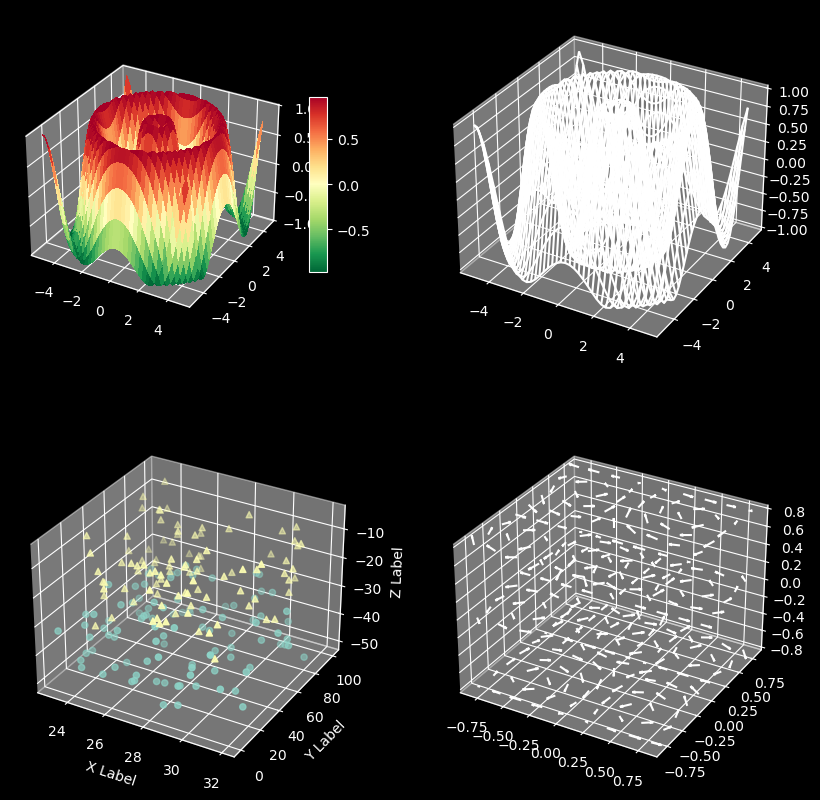

In [5]:
plt.clf()
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(10, 10))

# =============
# First subplot SURFACE
# =============
# set up the Axes for the first plot
ax = fig.add_subplot(2, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R*2)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdYlGn_r,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)
fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot WIREFRAME
# ==============
# set up the Axes for the second plot
ax = fig.add_subplot(2, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)

# =============
# Third subplot SCATTER
# =============
ax = fig.add_subplot(2, 2, 3, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# =============
# Fourth subplot QUIVER
# =============
ax = fig.add_subplot(2, 2, 4, projection='3d')

# Make the grid
x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.8))

# Make the direction data for the arrows
u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)

plt.show()

### Comparison of different 1 D functions and their mods

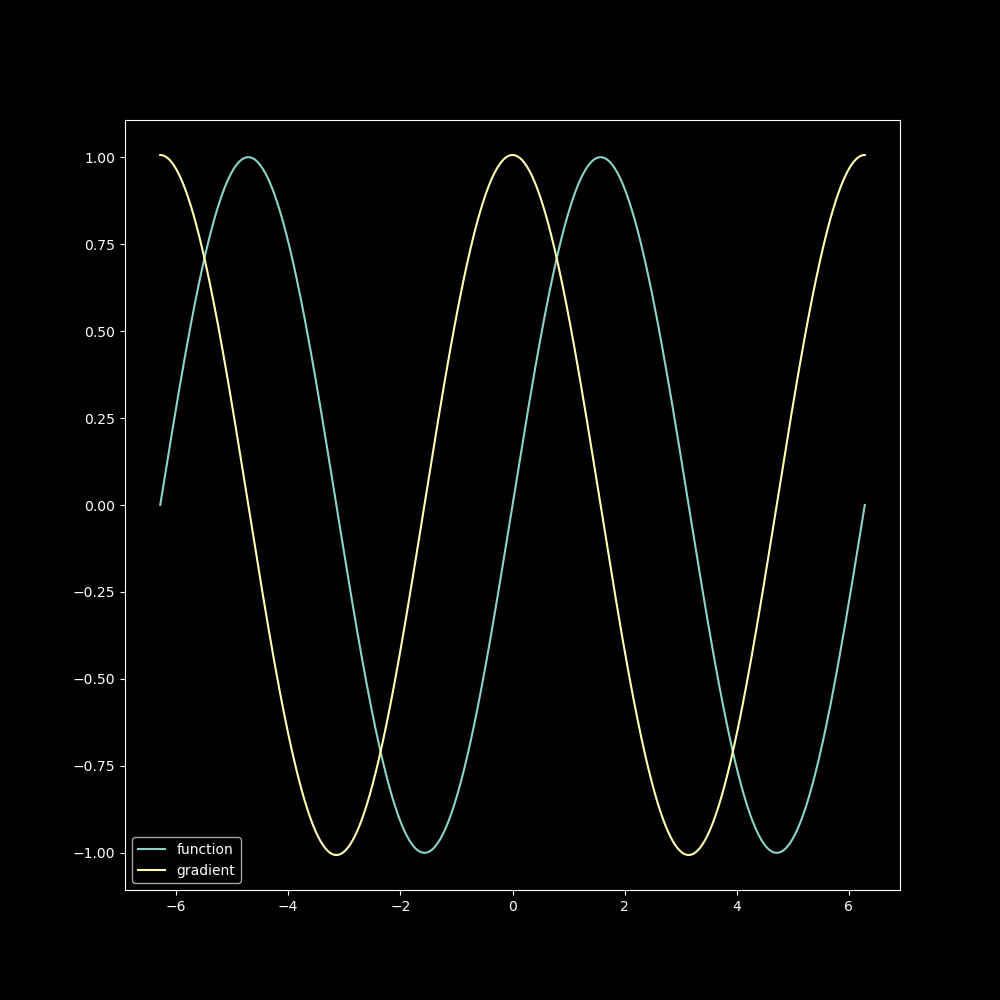

In [40]:
def simple_square(x):
    return np.sin(x)

def test_transform(fs: Any, ts: List[Any], xlim1: float=-10.0, xlim2: float=10.0, n: int=100, plot: bool=True) -> Dict[str, np.array]:
    """
    Takes list of functions and transformations, and returns dict of function values and numerical transformations' values
    on some linspace.
    
    Args:
        fs (function): takes a function you want to test transformations on
        ts (List[function]): takes a list of transformations you want to apply on your function
        xlim1 (float): linspace start, default -10
        xlim2 (float): linspace end, default 10
        n (int): number of points to work on, default 100
        plot (bool): plot the results? Default `True` 
    
    Returns:
        Dict[str,List[float]]: Function's and its transformations' evaluations in appropriate dictionary
    """
    xs = np.linspace(xlim1, xlim2, n)
    f_result = fs(xs)
    final_dict = {f"{fs}": f_result}

    for t in ts:
        final_dict[f"{t}"] = t(f_result)

    if plot:

        for fs, fr in final_dict.items():

            plt.plot(xs, fr, label=f"test transformation {fs}")
        plt.legend()
        plt.show()

    
    return final_dict

plt.clf()
# test_transform(simple_square, [np.gradient, lambda x: (abs(x) + np.pi/4)/2], xlim1=0, xlim2=2*np.pi)
xs = np.linspace(-2*np.pi, 2*np.pi, 1000)
ys = [simple_square(x) for x in xs]
ys_grad = np.gradient(ys)
plt.plot(xs, ys, label="function")
plt.plot(xs, 80*ys_grad, label="gradient")
plt.legend()
plt.show()

### Visualizations of operators

#### Custom/stock operators

In [3]:
# Setup a 2D grid
x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)
xx, yy = np.meshgrid(x, y)

def custom_gradient(f, point, h=1e-6):
    """
    Calculates the gradient of a function f at a given point.
    """
    point = np.asarray(point, dtype=float)
    grad = np.zeros_like(point)
    
    for i in range(len(point)):
        # Create a copy and add a small step 'h'
        point_plus = point.copy()
        point_plus[i] += h
        
        # Create a copy and subtract a small step 'h'
        point_minus = point.copy()
        point_minus[i] -= h
        
        # The partial derivative is (f(x+h) - f(x-h)) / 2h
        grad[i] = (f(point_plus) - f(point_minus)) / (2 * h)
        
    return grad

# Example usage:
def my_function(p):
    # f(x, y) = x^2 + y^3
    return p[0]**2 + p[1]**3

point = [2, 3]
# The analytical gradient is <2x, 3y^2> -> <4, 27>
print(f"Custom gradient: {custom_gradient(my_function, point)}")

Custom gradient: [ 4. 27.]


#### Gradient $\nabla f$ visualization

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_5845/2154645034.py:27: SyntaxWarning: invalid escape sequence '\s'
  plot_vector_field_3d(xx, yy, zz, df_dx, df_dy, df_dz, "Gradient of $f(x_i) = \sum_{i}x_i^2$")


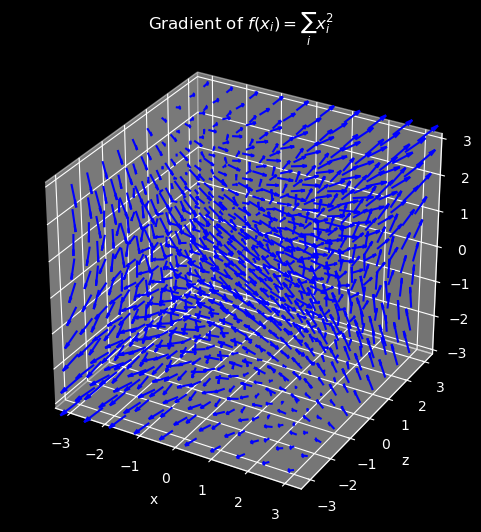

In [4]:
def plot_vector_field_3d(x, y, z, u, v, w, title=""):
    """Plots a 2D vector field using a quiver plot."""
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(x, y, z, u, v, w, length=0.1, color='b')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylabel('z')
    ax.axis('square')
    ax.grid()
    plt.show()

# 2D grid setup
x = np.linspace(-3, 3, 10)
y = np.linspace(-3, 3, 10)
z = np.linspace(-3, 3, 10)
xx, yy, zz = np.meshgrid(x, y, z)

# Scalar field f(x,y)
f = xx**2 + yy**2 + zz**2

# Calculate gradient: returns a list of arrays [df/dy, df/dx]
# NOTE: np.gradient returns derivatives in axis order (y, x for a 2D array)
df_dz, df_dy, df_dx = np.gradient(f)

plot_vector_field_3d(xx, yy, zz, df_dx, df_dy, df_dz, "Gradient of $f(x_i) = \sum_{i}x_i^2$")

#### Divergence $\nabla \cdot \textbf{F}$ visualization

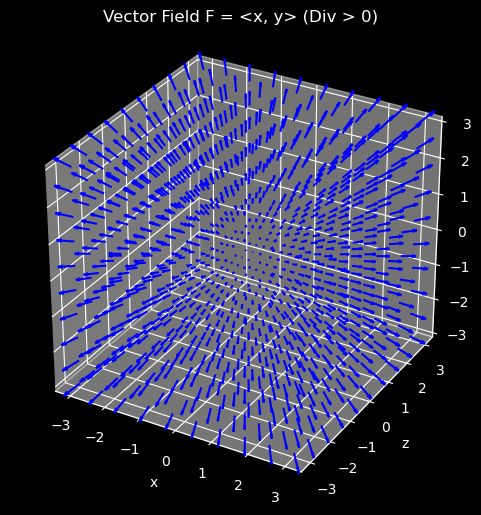

In [6]:
# Vector field F = <u, v>
u, v, w = xx, yy, zz  # u is the x-component, v is the y-component

# Calculate divergence: Div(F) = du/dx + dv/dy
dw_dz, _, _ = np.gradient(w)
_, dv_dy, _ = np.gradient(v) # We only need the y-derivative of v
_, _, du_dx = np.gradient(u) # We only need the x-derivative of u

divergence = du_dx + dv_dy + dw_dz

# We can visualize the original field
plot_vector_field_3d(xx, yy, zz, u, v, w, "Vector Field F = <x, y> (Div > 0)")
# And its divergence (which is a scalar field)
# print("Divergence (approx):", np.mean(divergence)) # Should be ~2.0

#### Curl $\nabla \times \textbf{F}$ visualization

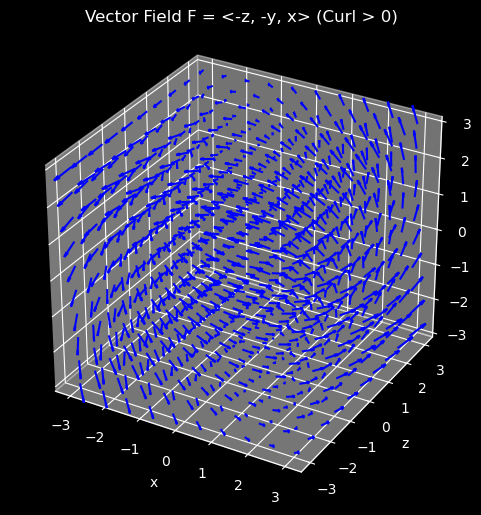

Curl (approx): 0.0


In [7]:
# Vector field F = <u, v>
u, v, w = -zz, yy, xx

# Calculate 2D Curl: Curl(F) = dv/dx - du/dy
_, _, dw_dx = np.gradient(w)
_, dv_dy, _ = np.gradient(v)
du_dz, _, _ = np.gradient(u)

curl_z = dw_dx - dv_dy - du_dz # This is the z-component of the 3D curl

# We visualize the original rotating field
plot_vector_field_3d(xx, yy, zz, u, v, w, "Vector Field F = <-z, -y, x> (Curl > 0)")
# And its curl (which is a scalar in 2D)
print("Curl (approx):", np.mean(curl_z)) # Should be ~2.0


### Scattering book theory/equations w/ explained variables and possibly some python functions

The following is theory equations and all variable names for the theory from Bohren scattering book

$\mathbf{D}$ $\text{--}$ electric displacement

$\mathbf{E}$ $\text{--}$ electric field

$\mathbf{B}$ $\text{--}$ magnetic induction

$\mathbf{H}$ $\text{--}$ magnetic field

$\mathbf{P}$ $\text{--}$ electric polarization

$\mathbf{M}$ $\text{--}$ magnetization (average magnetic dipole moment per unit volume)

$\mathbf{\epsilon_0}$ $\text{--}$ permittivity

$\mathbf{\mu_0}$ $\text{--}$ permeability

The following are _macroscopic_ Maxwell equations, for derivation from microscopic see Rusakoff (1970) and Robinson (1973)

$
\begin{equation}
\nabla \cdot \mathbf{D} = \rho_{\mathbf{F}}
\end{equation}
$

$
\begin{equation}
\nabla \times \mathbf{E} + \dfrac{\partial \mathbf{B}}{\partial t} = 0
\end{equation}
$

$
\begin{equation}
\nabla \cdot \mathbf{B} = 0
\end{equation}
$

$
\begin{equation}
\nabla \times \mathbf{H} = \mathbf{J}_{\mathbf{F}} + \dfrac{\partial \mathbf{D}}{\partial t}
\end{equation}
$